# Preprocessing & Evaluation

## Preprocessing data (one-hot-encoding, normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1. 
This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).
There is another process called **standardization**, which converts all of the data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline, a series of functions to prepare the data for use with neural networks.

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks we tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

To demeonstrate that, we will use the medical insurance regression example again.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

2025-11-04 15:23:21.576349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 15:23:21.576420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 15:23:21.577214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 15:23:21.583902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get a glimpse of the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [4]:
# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

How does our data look after normalization and one-hot encoding? 

In [5]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [6]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

How about the shapes?

In [7]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train.shape, X_train_normal.shape

((1070, 6), (1070, 11))

Our data is normalized and numerical, let's train a model.

We'll use the same model as `insurance_model_2` in the previous NB.

In [8]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history = insurance_model_3.fit(X_train_normal, y_train, epochs=300, verbose=1) 

Epoch 1/300


2025-11-04 15:23:25.700668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2025-11-04 15:23:26.542800: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f99c9c9ea10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 15:23:26.542854: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-11-04 15:23:26.548906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-04 15:23:26.568596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1762266206.665082 1962708 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at mo

34/34 [==============================] - 1s 2ms/step - loss: 13344.1465 - mae: 13344.1465
Epoch 2/300
34/34 [==============================] - 0s 2ms/step - loss: 13337.1650 - mae: 13337.1650
Epoch 3/300
34/34 [==============================] - 0s 2ms/step - loss: 13318.6475 - mae: 13318.6475
Epoch 4/300
34/34 [==============================] - 0s 1ms/step - loss: 13278.3408 - mae: 13278.3408
Epoch 5/300
34/34 [==============================] - 0s 1ms/step - loss: 13205.3008 - mae: 13205.3008
Epoch 6/300
34/34 [==============================] - 0s 1ms/step - loss: 13088.8809 - mae: 13088.8809
Epoch 7/300
34/34 [==============================] - 0s 1ms/step - loss: 12918.8545 - mae: 12918.8545
Epoch 8/300
34/34 [==============================] - 0s 2ms/step - loss: 12684.9639 - mae: 12684.9639
Epoch 9/300
34/34 [==============================] - 0s 1ms/step - loss: 12376.9023 - mae: 12376.9023
Epoch 10/300
34/34 [==============================] - 0s 2ms/step - loss: 11988.7666 - mae: 11

Let's evaluate the model on the normalized test set.

In [9]:
# Evaulate 3rd model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 3161.1619 - mae: 3161.1619


And finally, let's compare the results from `insurance_model_2` (trained on non-normalized data) and `insurance_model_3` (trained on normalized data). For that, we will load the model first.

In [10]:
insurance_model_2 = tf.keras.models.load_model('./insurance_model_2.keras')

We need to (only) one-hot encode our data for the `insurance_model_2`

In [11]:
ct_one_hot = make_column_transformer(
    (SimpleImputer(), ["age","bmi","children"]),
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])) # remainder makes sure the numeric columns do't get dropped

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct_one_hot.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_one_hot = ct_one_hot.transform(X_train)
X_test_one_hot = ct_one_hot.transform(X_test)

In [12]:
X_test_one_hot

array([[45.   , 25.175,  2.   , ...,  0.   ,  0.   ,  0.   ],
       [36.   , 30.02 ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [64.   , 26.885,  0.   , ...,  1.   ,  0.   ,  0.   ],
       ...,
       [38.   , 28.025,  1.   , ...,  0.   ,  0.   ,  0.   ],
       [54.   , 47.41 ,  0.   , ...,  0.   ,  1.   ,  0.   ],
       [51.   , 34.2  ,  1.   , ...,  0.   ,  0.   ,  1.   ]])

In [13]:
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test_one_hot, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 3223.4307 - mae: 3223.4307


In [14]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

(3223.4306640625, 3161.161865234375)

From this we can see normalizing the data results in a smaller error using the same model than not normalizing the data.
One of the main benefits of normalization, however,  is faster convergence time.
`insurance_model_2` may have eventually achieved the same results as `insurance_model_3` if we left it training for longer. 
Obviously, the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

## Callbacks
"Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle." Source: TensorFlow documentation.

There are many different callbacks you can set. In fact, you can also create your custom callbacks.
I would like to point out just two very useful callbacks here: [**early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping), and [**TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). We could (or should) pass all the callbacks in one [callbacks list](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CallbackList). However, to better demonstrate what each callback does, I will go through them seperately.

### Early stopping callback
It is often hard to tell for how many epochs you should let your models train, without risking under- or overfitting. In this situation the early stopping callback comes in handy.
It simply stops the training, as soon as a predefined metric is no longer improving. You can decide what the tolarance should be to define "no longer improving" by passing `min_delta`, and how many epochs the callback should wait before interrupting the training by passing the `patience` argument.

Let's have a look how it works on our last model. We will set the number of epochs to 500 to provoke early stopping.
For some reason, which is not quite obvious, we have to build and compile model_3 again as model_4 to make the callback work.

In [15]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) # Training will stock, if there is no improvement on the loss after 5 consecutive epochs

In [16]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_4.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

In [17]:
# Here, we also pass the test sets as `validation_data`, to get an imporesson, if and when the model overfits
history_callback = insurance_model_4.fit(X_train_normal, y_train, epochs=500, validation_data = (X_test_normal, y_test), callbacks=callback_early_stopping, verbose=1)

Epoch 1/500
34/34 [==============================] - 1s 5ms/step - loss: 13344.3848 - mae: 13344.3848 - val_loss: 12963.9102 - val_mae: 12963.9102
Epoch 2/500
34/34 [==============================] - 0s 2ms/step - loss: 13337.1318 - mae: 13337.1318 - val_loss: 12952.2607 - val_mae: 12952.2607
Epoch 3/500
34/34 [==============================] - 0s 2ms/step - loss: 13318.2988 - mae: 13318.2988 - val_loss: 12923.5605 - val_mae: 12923.5605
Epoch 4/500
34/34 [==============================] - 0s 2ms/step - loss: 13276.6309 - mae: 13276.6309 - val_loss: 12865.6787 - val_mae: 12865.6787
Epoch 5/500
34/34 [==============================] - 0s 2ms/step - loss: 13200.1406 - mae: 13200.1406 - val_loss: 12767.0801 - val_mae: 12767.0801
Epoch 6/500
34/34 [==============================] - 0s 3ms/step - loss: 13077.8203 - mae: 13077.8203 - val_loss: 12617.5117 - val_mae: 12617.5117
Epoch 7/500
34/34 [==============================] - 0s 2ms/step - loss: 12899.3320 - mae: 12899.3320 - val_loss: 1240

In [18]:
len(history_callback.history['loss'])

225

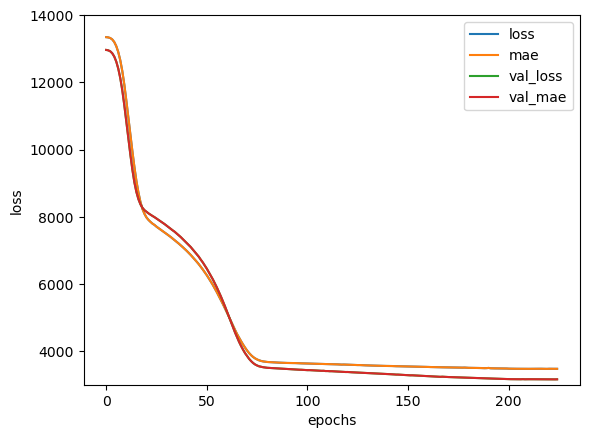

In [19]:
# Plot the model with early stopping callback
pd.DataFrame(history_callback.history).plot()
plt.ylim(3000, 14000)
plt.ylabel("loss")
plt.xlabel("epochs");

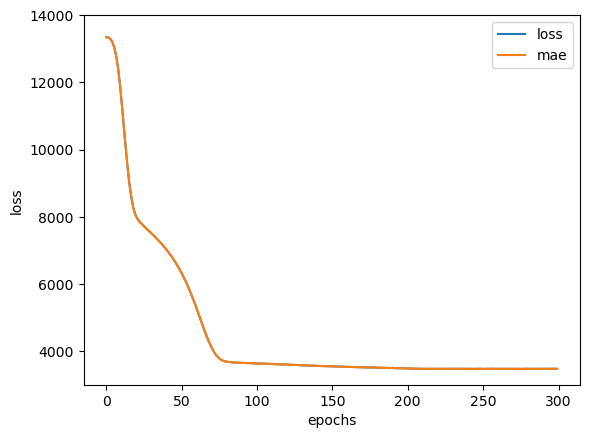

In [20]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history.history).plot()
plt.ylim(3000, 14000)
plt.ylabel("loss")
plt.xlabel("epochs"); 

I seems we were pretty close to the minimum loss with 200 epochs.

### TensorBoard callback
The TensorFlow documentation describes this the following way: "TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more."
Let's see it in action:

In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [22]:
import datetime

In [23]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [24]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_6.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

In [26]:
insurance_model_6_history = insurance_model_6.fit(X_train_normal, y_train, epochs=200, validation_data = (X_test_normal, y_test), callbacks=tensorboard_callback, verbose=0)

To start TensorBoard on the VSC JupyterHub, we need to bend over backwards a little bit. Thankfully, Katrin Muck from the VSC, wrote these cells of code to make it possible.

In [27]:
import random
import os
username = os.getenv('USER')
if 'trainee' in username:
    trainee_number = int(username.replace('trainee', ''))
else:
    trainee_number = hash(username) % 100
TENSORBOARD_PORT = 63000 + trainee_number
print('tensorboard will be available at:')
URL = f'https://jupyterhub.vsc.ac.at/user/{username}/proxy/{TENSORBOARD_PORT}/'
print(URL)

tensorboard will be available at:
https://jupyterhub.vsc.ac.at/user/trainee40/proxy/63040/


In [28]:
%set_env TENSORBOARD_PROXY_URL=$URL

env: TENSORBOARD_PROXY_URL=https://jupyterhub.vsc.ac.at/user/trainee40/proxy/63040/


In [29]:
%tensorboard --logdir logs/fit --bind_all --port $TENSORBOARD_PORT

Ignore the error message. Instead open the following url in a new tab: https://jupyterhub.vsc.ac.at/user/traineexx/proxy/630xx/ with xx being your trainee ID.